# Data Preparation

In this step, we will analyze different transformation candidates for numeric features (original and derived) as well as one hot encode categorical features.

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from toolkit import Viz, Tools, PF

# Pre configure modules
warnings.filterwarnings('ignore')
sns.set()

In [3]:
# Function to reset data to original structures. With new features added.
def reset_data():
    data, _, _, _ = PF.import_data()
    X, y = data[PF.cat_cols + PF.num_cols], data[PF.target_col]
    X = PF.add_features(X, y)

    return data, X, y

# Get data
data, X, y = reset_data()

---
## Metric Transformations

Among metric transformation options we will consider Power Transformation (Yeo Johnson approach), Quartile Transformation or Standardization (either Normal or Min Max).

For an easier exploration, the following function was built. It receives as input, a feature matrix and a dictionary where each key (metric name) specifies the type of transformation desired.

The transformation codes used are:

- `'yj'` for Power Transformation.
- `'qt'` for Quantile Transformation.
- `'nrm'` for Normal Standardization.
- `'mnmx'` for Min Max Standardization.
- `'none'` for Not Transformation at all.

**Note:** Detailed code for each transformation function performed can be found in the `Tools` class of the **toolkit.py** file. I encourage you to check them out.

In [6]:
# Function to perform transformations by column
def transform(X, c_trans):
    for c, t in c_trans.items():
        if t == 'yj': xt = Tools.power_transform(X[[c]], standardize=True)
        elif t == 'qt': xt = Tools.quantile_transform(X[[c]])
        elif t == 'nrm': xt = Tools.standardize(X[[c]], which='normal')
        elif t == 'mnmx': xt = Tools.standardize(X[[c]], which='minmax')
        else: xt = X[[c]]

        X[c] = xt[c]

    return X

c_trans = {}

### Base Metrics Transformations

In [4]:
# Visualize base metrics distributions without any transformation for comparison
# Undocument and execute if required

#Viz.kernel_plot(X, y, c_plot=PF.num_cols, remove_val=[None], rug_sample=2500)

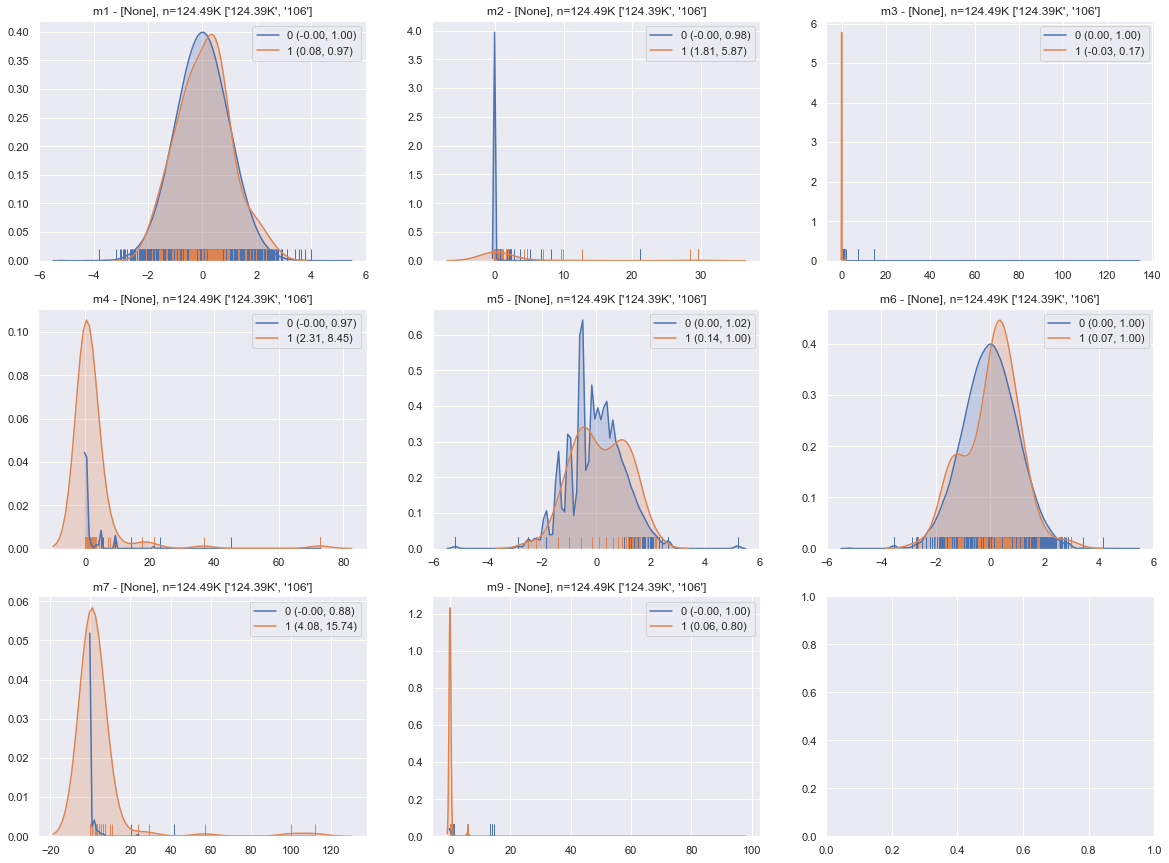

In [8]:
# Transform base metrics. You can experiment as desired.
data, X, y = reset_data()
c_trans['m'] = {'m1': 'qt', 'm2':'nrm', 'm3':'nrm', 
                'm4':'nrm', 'm5':'qt', 'm6':'qt',
                'm7':'nrm', 'm9':'nrm'}

X = transform(X, c_trans['m'])
data = pd.concat([X, y], axis=1)

# Visualize transformed metrics
Viz.change_default(3)
Viz.kernel_plot(X, y, c_plot=c_trans['m'].keys(), remove_val=[None], rug_sample=2500)

### Base Metrics Transformations - Conclusions
Power Transformation seem to not add much value to data than a simple standardization.
Quartile Transformation makes a good job approximating M1, M5, M6 to normal distributions. Overlap between target remains and even is powered.
Normal Standardization / Min Max Standardization shifts and scales data but leaves original distribution.

Transformation Decisions:
- Transformations will be required only for linear based models, since its ideal to pursue normality in data.
- M1, M5, M6 will be Quartile transformed.
- M2, M3, M4, M7, M9 will be normal standardized so that everything is in terms of normal standard deviations.


### Change Metrics Transformations

In [9]:
# Visualize change metrics distributions without any transformation for comparison
# Undocument and execute if required

#Viz.kernel_plot(X, y, c_plot=PF.chng_cols, remove_val=[None], rug_sample=2500)

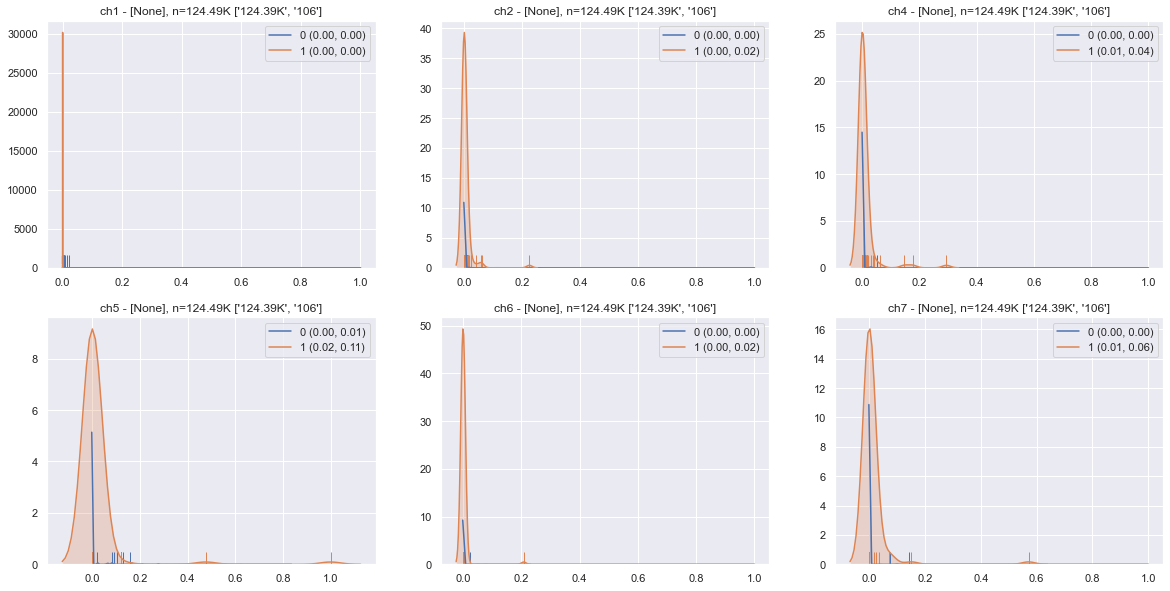

In [10]:
# Transform change metrics. You can experiment as desired.
data, X, y = reset_data()
c_trans['ch'] = {'ch1': 'mnmx', 'ch2':'mnmx', 'ch4':'mnmx', 
                 'ch5':'mnmx', 'ch6':'mnmx', 'ch7':'mnmx'}

X = transform(X, c_trans['ch'])
data = pd.concat([X, y], axis=1)

# Visualize transformed change metrics
Viz.kernel_plot(X, y, c_plot=c_trans['ch'].keys(), remove_val=[None], rug_sample=2500)

### Change Metrics Transformations - Conclusions

Transformation Decisions:

- Change percentage by itself is expected to be normalized, so transformations won't make much difference.
- Each change metric uses different scales. A Max Min standardization will translate into a common one.

### Rank Metrics Transformations

In [11]:
# Visualize rank metrics distributions without any transformation for comparison
# Undocument and execute if required

#Viz.kernel_plot(X, y, c_plot=PF.rnk_cols, remove_val=[None], rug_sample=2500)

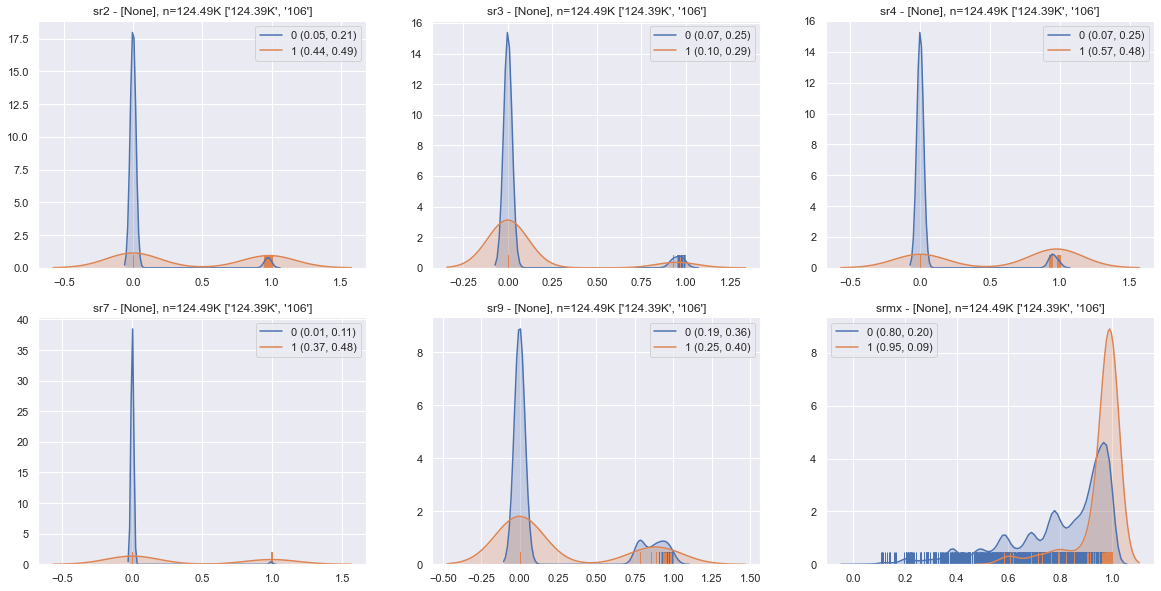

In [12]:
# Transform rank metrics. You can experiment as desired.
data, X, y = reset_data()
c_trans['sr'] = {'sr2': 'none', 'sr3':'none', 'sr4':'none', 
                 'sr7':'none', 'sr9':'none', 'srmx':'none'}

X = transform(X, c_trans['sr'])
data = pd.concat([X, y], axis=1)

# Visualize transformed change metrics
Viz.kernel_plot(X, y, c_plot=c_trans['sr'].keys(), remove_val=[None], rug_sample=2500)

### Rank Metrics Transformations - Conclusions
Transformation Decisions:

- No transformation or standardization is required. Data is spread between 0 and 1 already.

---
## Multicollinearity

As we saw previously, some metrics show small or moderate correlation. This can negatively affect linear models since it will introduce redundancy in training step. Bellow we will review such collinearity and how it will be assessed.

### Metrics Correlation

In [13]:
# Perform all transformations on data
c_trans['m'] = {'m1': 'qt', 'm2':'nrm', 'm3':'nrm', 'm4':'nrm', 
                'm5':'qt', 'm6':'qt', 'm7':'nrm', 'm9':'nrm'}
c_trans['ch'] = {'ch1': 'mnmx', 'ch2':'mnmx', 'ch4':'mnmx', 
                 'ch5':'mnmx', 'ch6':'mnmx', 'ch7':'mnmx'}
c_trans['sr'] = {'sr2': 'none', 'sr3':'none', 'sr4':'none', 
                 'sr7':'none', 'sr9':'none', 'srmx':'none'}

data, X, y = reset_data()
for k in c_trans.keys(): X = transform(X, c_trans[k])
data = pd.concat([X, y], axis=1)

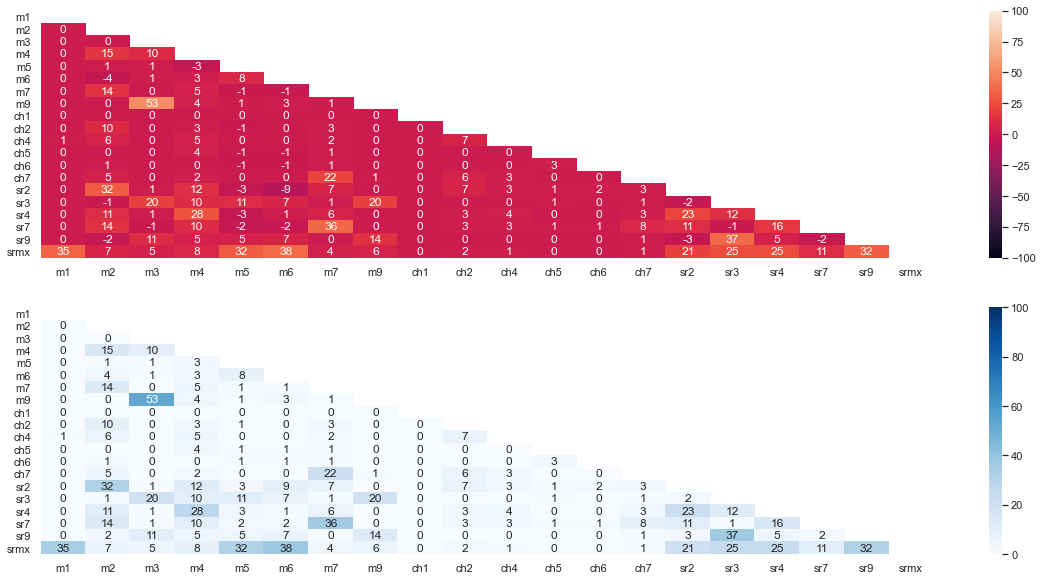

In [14]:
# Check correlation between rank metrics and base metrics
corr_matrix = Tools.get_corr(X, PF.nnum_cols)
Viz.change_default(1)
Viz.corr_plot(corr_matrix)

### Metrics Correlation - Conclusion

- Correlation is minimum among metrics after transformations.
- Few cases need to be assessed. PCA can remove all collinearity.

### PCA (Principal Component Analysis)

PCA can help eliminate all collinearity in the numeric features (no matter how small). This will ensure that linear models are not negatively impacted.

The execution of this algorithm as well as the visualization of its results will be leveraged by some built tools. This can be found in `Tools` and `Viz` classes in **toolkit.py** file. I encourage you to see them:

```python
class Viz():
    def screeplot(cls, pca_var, pca_labels):
        """ Plots screeplot for PCA Analysis. Will display explained variance and cummuative explained var."""
    
class Tools():
    def pca(cls, X, c_pca):
        """ Executes PCA on X for specified columns"""
```

When plotting the scree plot chart. Note that the bars in the plot represent the explained variance per component. The line represents the cumulative explained variance.

For now, no dimensionality reduction will be performed.

In [16]:
# Test PCA on all numeric features
c_pca = PF.nnum_cols
Xpca, pca_var = Tools.pca(X, c_pca)
pca_cumvar = np.cumsum(pca_var)

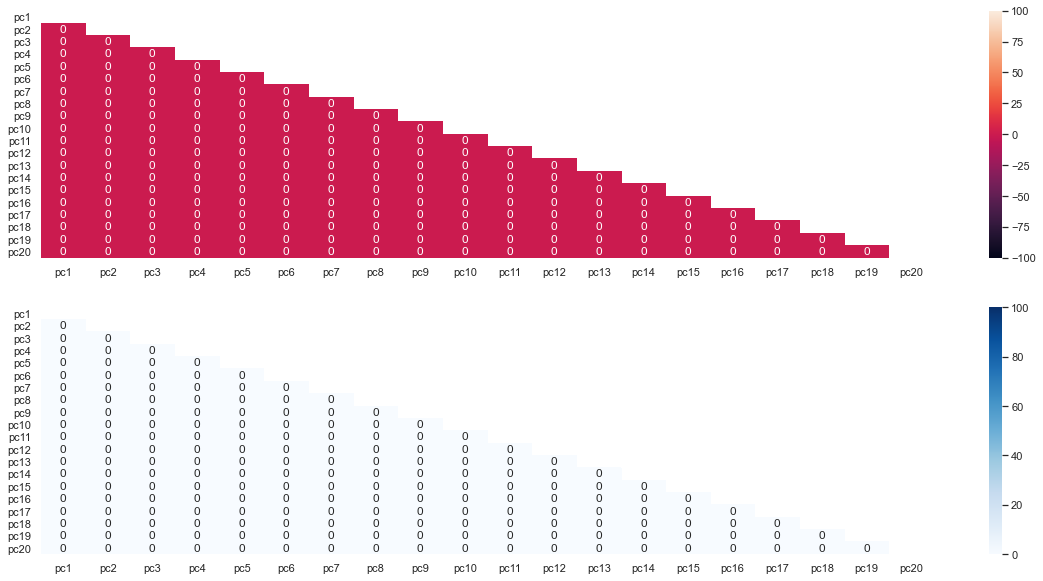

In [18]:
# Check correlation between pca components
corr_matrix = Tools.get_corr(Xpca, Xpca.columns)
Viz.corr_plot(corr_matrix)

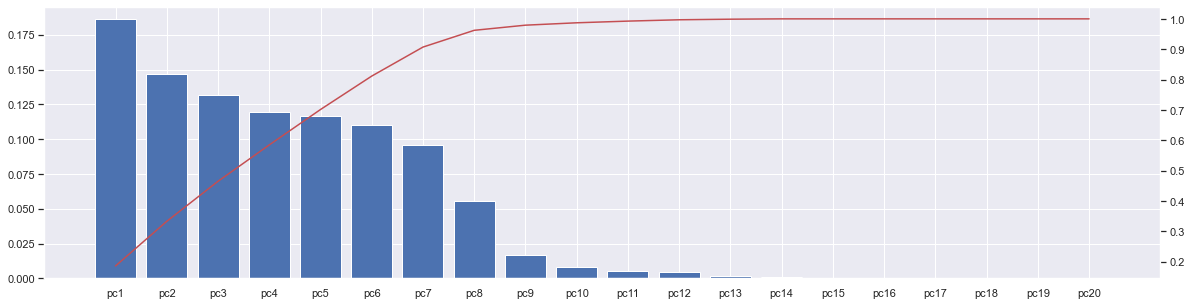

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
var,0.185972,0.147081,0.131836,0.119825,0.116650,0.110127,0.095545,0.055215,0.016926,0.007860,0.005529,0.004404,0.001904,0.001106,0.000011,0.000003,0.000002,0.000002,0.000002,0.000001
cumvar,0.185972,0.333053,0.464889,0.584714,0.701364,0.811491,0.907035,0.962250,0.979176,0.987036,0.992565,0.996969,0.998873,0.999979,0.999990,0.999992,0.999995,0.999997,0.999999,1.000000


In [17]:
# Vizualise Screeplot
Viz.screeplot(pca_var, Xpca.columns)

# Print PCA variance and cummulative variance values
pca_var = [{'var':pca_var[i], 'cumvar':pca_cumvar[i]} for i, _ in enumerate(Xpca.columns)]
pca_var = pd.DataFrame(pca_var, index=Xpca.columns)
pca_var.transpose()

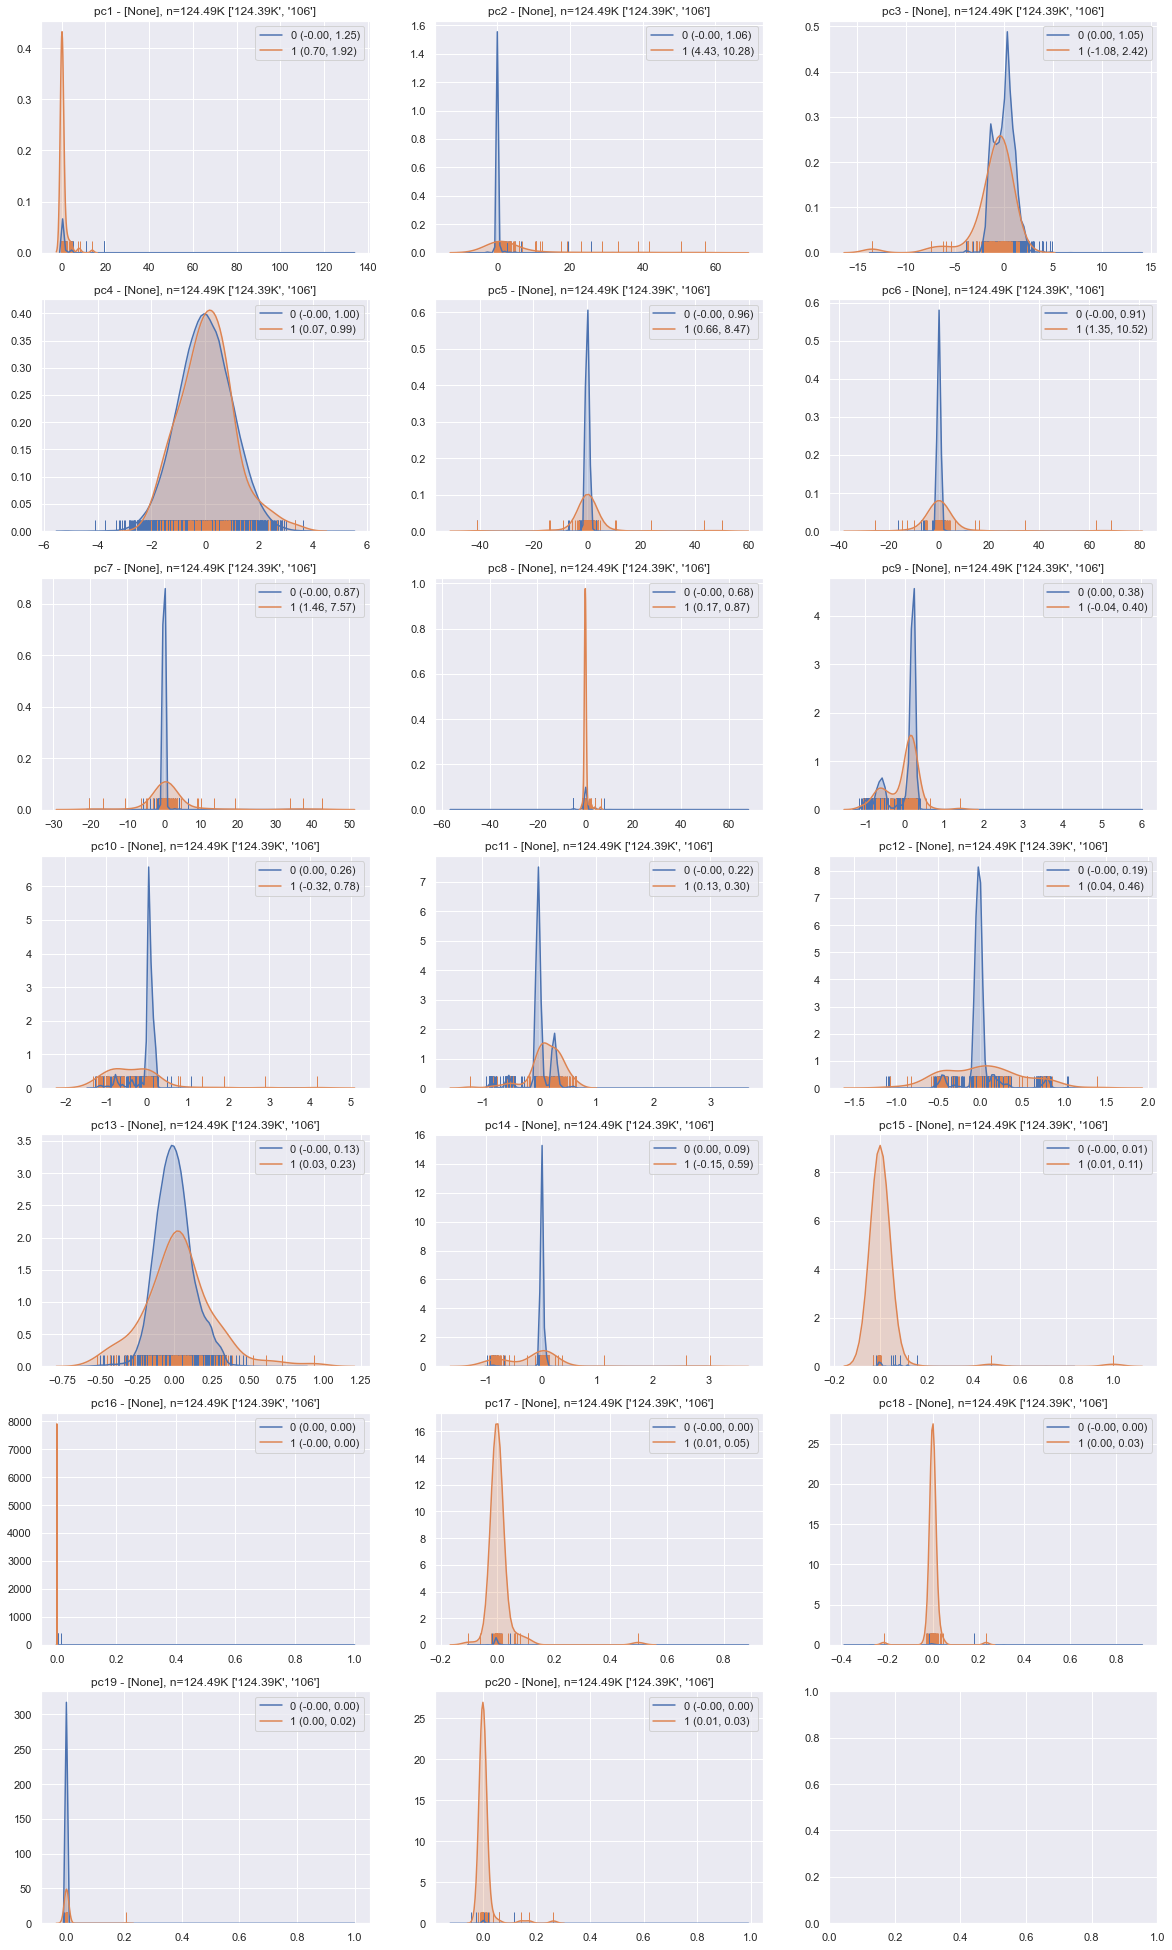

In [20]:
# Create distribution plot per pca and target
Viz.change_default(3)
Viz.kernel_plot(Xpca, y, c_plot=Xpca.columns, remove_val=[None], rug_sample=2500)

### PCA - Conclusion

- PCA decomposition effectively eliminates any multicollinearity present in data.
- Although last 10 components explain close to 1% of variance, they will not be removed since target itself has a 999:1 unbalance. Perhaps is in this features that differences emerge.
- Additionally, in many of these last components, failure values are more easily separable which will enhance model results.

---
## Category Encoding

For category features the case is pretty straightforward.

One Hot Encoding will be performed. Eliminating one redundant column per feature dummy set.

This transformation will be performed leveraging built tools that can be found in `Tools` class of **toolkit.py** file. These functions are:

```python
def oh_encode(cls, X, c_enc):
        """ One Hot Encodes categorical data"""
```

In [22]:
# One Hot Encode categorical features
cat_cols = [c for c in PF.ncat_cols if c not in PF.cat_cols]
Xenc, enc_cols = Tools.oh_encode(X[cat_cols], cat_cols)

# Check new data dimension size
Xenc.shape[1]

63

### Category Encoding - Conclusion

- One Hot Encoding was performed eliminating one value per category to avoid redundancy. 
- Dimensionality increased. If it is an issue for model performance, reduction techniques will be designed.